# Code for more traditional compression experiments in our compression paper

i.e. this includes everything but the ML part

## This reads in the 2D weak lensing data set  

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow_datasets as tfds
#import tensorflow_compression as tfc
import re
import random
import numpy as np
import os
from astropy.io import fits

# Specify the directory containing the .tar files
directory_path = '../weaklensing_ML/columbialensing/'
number_image_files = 512 #goes up to 512, but you might train on fewer

single_cosmology = True #if true, only use one cosmology
# image_size
image_size = 1024
sub_image_size = 1024 #needs to divide image into these units; must divide evenly image_size
                    #division is using that it is unlikely there are learnable correlations
                    #that allow one to compress the data on large scales in the images
                    #dividing images gives more samples to learn correlations

num_images_use = image_size**2//sub_image_size**2*number_image_files

number_subimages_across =image_size//sub_image_size



suffix = f"_{image_size}"
extract_tarfiles = False  #if I need to extract tarfiles

run_suffix = rf"im{image_size}"



def get_labels_for_file(dir_name):
    """
    Extracts labels from the tar file name.
    For the file "Om0.183_si0.958_256.tar", the labels will be [0.183, 0.958].

    Args:
    - tar_file_name (str): Name of the tar file.

    Returns:
    - list: List containing the two labels extracted from the filename.
    """
    # Split the filename on underscores
    if dir_name.endswith('.tar'):
        dir_name = dir_name[:-4]

    parts = dir_name.split('_')

    # Extract the numeric values for 'Om' and 'si'
    om_label = float(parts[0][2:])
    si_label = float(parts[1][2:])
    print (om_label, si_label)

    return [om_label, si_label]

#selects the numdirs closest to the fiducial directory
#STILL WORKING ON THIS CODE
def select_some_directories(numdirs, fiducial_dir):
    all_directories = [f for f in os.listdir(directory_path) if '128' not in f and '256' not in f]
    print(all_directories)
    #cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)
    fiducial_label = get_labels_for_file(fiducial_dir)
    labels = [get_labels_for_file(directory) for directory in all_directories] 
    print(labels)
    #to evlauate closeness
    closeness = pow(labels[:][0]/.3, 0.5)*label[:][1]
    fiducial = pow(fiducial_label[0]/.3, 0.5)*fiducial_label[1]

    #sort by closeness
    sorted_closeness = np.argsort(np.abs(closeness-fiducial))
    #select numdirs closest
    selected_dirs = sorted_closeness[:numdirs]
    return [all_directories[i] for i in selected_dirs]

#now loop through all files in the
pattern = re.compile(rf"{suffix}$")

if single_cosmology:
    all_directories = ["Om0.268_si0.801"] # "Om0.283_si0.805_256"
else:
    numdirs = 10
    all_directories = select_some_directories(numdirs, "Om0.268_si0.801")
    print(all_directories)


num_cosmologies = len(all_directories)

random.shuffle(all_directories) #this makes it so that there is no particular order for the directories
#print(all_directories)

#tensor of labels; there are two labels for each
numsubimages = number_subimages_across**2
number_images = number_image_files*numsubimages
#cosmology_labels = np.empty((len(all_directories), number_images, 2), dtype=np.float16)

RMS =False #first time set to zero
LOGFIELD = False
data_array = np.empty((num_cosmologies, number_images, sub_image_size, sub_image_size), dtype=np.float32)
for idy, dir_name in enumerate(all_directories):


    #if idy%10 ==0:
    print("reading in", dir_name)
    dir_path = os.path.join(directory_path, dir_name)

    all_files = os.listdir(dir_path)
    fits_files = [f for f in all_files if f.endswith('.fits')]



    for idx, file in enumerate(fits_files):
        with fits.open(os.path.join(dir_path, file)) as hdul:

            original_data = hdul[0].data #take log of data 

            #if RMS == 0: #get RMS to divide by for first file to normalize everything
            #    RMS = np.sqrt(np.var(hdul[0].data))
            #    print(f"RMS={RMS}")

            ##get rid of NANs, which affects a few files
            #if np.isnan(original_data).any():
            #    continue
            #I've cleaned this out already
            for i in range(number_subimages_across):
                for j in range(number_subimages_across):
                    data_array[idy][numsubimages*idx+ number_subimages_across*i+j] = original_data[sub_image_size*i:sub_image_size*(i+1),\
                                                                  sub_image_size*j:sub_image_size*(j+1)]
    #since all fits files in one directory have the same label
    cosmology = get_labels_for_file(dir_name)
    #cosmology_labels[idy] = np.array([cosmology for i in range(number_fits_files)])


    #flatten data_array[idy][numsubimages*idx+ number_subimages_across*i+j]

if LOGFIELD:
    meanf = np.mean(data_array)
    stdf = np.std(data_array)
    minf = np.min(data_array)
    data_array = np.log((data_array-minf)/stdf + 1e-3)  #this was 1e-30 before 10/29/24, but 1e-3 makes sense to me
    print("LOGFIELD = True :  mean, std, min", meanf, stdf, minf)
elif RMS:
    stdf = np.std(data_array)
    data_array = data_array/stdf
    print("RMS = True : std", stdf)

WL_tensor = tf.convert_to_tensor(data_array)

WL_tensor = tf.reshape(WL_tensor, (-1, WL_tensor.shape[2], WL_tensor.shape[3]));

WL_tensor = WL_tensor[..., np.newaxis]  # Add channel dimension




reading in Om0.268_si0.801
0.268 0.801


2026-02-26 12:38:52.513531: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-02-26 12:38:52.513619: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2026-02-26 12:38:52.513628: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2026-02-26 12:38:52.513801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-26 12:38:52.513821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## This makes one image to make sure things are working correctly

2026-02-26 12:38:55.127989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


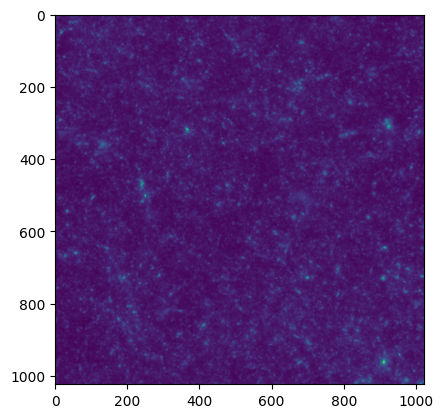

In [2]:
dataset = tf.data.Dataset.from_tensor_slices(WL_tensor)
#training_dataset = dataset.take(train_size)
(originals), =  dataset.batch(num_images_use).take(1) #simpler problem to start with

plt.imshow(tf.squeeze(originals[255]))

## Gaussian compression

The following implements the Gaussian compression algorithm.  We could just use the power spectrum to calculate how well this would work on the WL, but this assumes Gaussianity.  We will later check how many extra bits we have to store compared to if the data were Gaussian.

### This calculates the 2D power spectrum of these files, which we are going to need for compression

the kinks in power at high k are due to how particles are gridded in the simulation.  This is going to matter for compression as most modes are near the Nyquist wavenumber

shape: 1024 is_3d: False


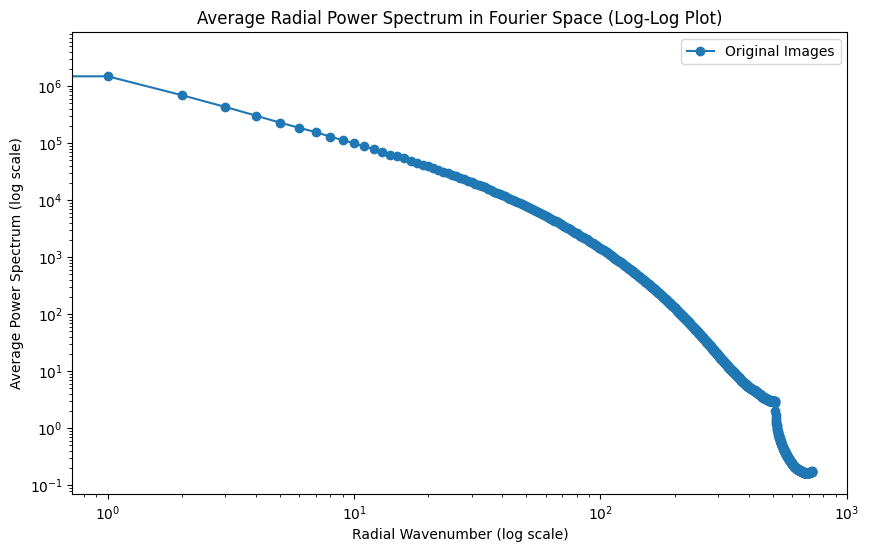

In [3]:
import power_spectrum as power
    
#fft's of array
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
fftimages = [np.fft.rfft2(image) for image in tf.squeeze(originals)]
avg_power = np.mean(np.abs(fftimages)**2)

avg_radial_power_spectrum_originals = power.average_fft_power_spectrum(fftimages, sub_image_size) # does not need to be subimage size



plt.figure(figsize=(10, 6))

# Plot for originals with markers
plt.loglog(avg_radial_power_spectrum_originals, label='Original Images', marker='o', linestyle='-')

#plt.loglog(average_fft_cross_power_spectrum(fftimages,fftimages, sub_image_size), label='cross', marker='x', linestyle='-') #for testing

plt.xlabel('Radial Wavenumber (log scale)')
plt.ylabel('Average Power Spectrum (log scale)')
plt.title('Average Radial Power Spectrum in Fourier Space (Log-Log Plot)')
plt.legend()

plt.show()



# Loyd max quantizer 

This compresses Gaussian IID pixels into nearly optimal bins.

In [4]:
import numpy as np
from scipy.stats import norm
from scipy.special import erf

def lloyd_max_quantizer(mu, sigma, levels):
    # Initialize decision boundaries
    decision_boundaries = np.linspace(mu - nsigma_consider*sigma, mu + nsigma_consider*sigma, levels+1)

    # Initialize reconstruction levels
    reconstruction_levels = np.zeros(levels)

    while True:
        # Update reconstruction levels
        for i in range(levels):
            left_boundary = decision_boundaries[i]
            right_boundary = decision_boundaries[i+1]
            #reconstruction_levels[i] = norm.expect(lambda x: x, args=(mu, sigma), lb=left_boundary, ub=right_boundary) / \
            #                           norm.expect(lambda x: 1, args=(mu, sigma), lb=left_boundary, ub=right_boundary)
            reconstruction_levels[i] = norm.expect(lambda x: x, loc=mu, scale=sigma, lb=left_boundary, ub=right_boundary) / \
                           norm.expect(lambda x: 1, loc=mu, scale=sigma, lb=left_boundary, ub=right_boundary)

        

        # Update decision boundaries
        new_decision_boundaries = (reconstruction_levels[:-1] + reconstruction_levels[1:]) / 2

        # Check for convergence
        if np.allclose(new_decision_boundaries, decision_boundaries[1:-1]):
            break

        decision_boundaries[1:-1] = new_decision_boundaries

    return decision_boundaries, reconstruction_levels


def uniform_quantizer(mu, sigma, levels):
    # Calculate the step size



    if(sigma !=1 or mu !=0):
        print("Warning: uniform quantizer assumes mu=0 and sigma=1")
        return -1

    reconstruction_levels = np.zeros(levels)    
    # Initialize decision boundaries
    decision_boundaries = np.linspace(mu - nsigma_consider*sigma, mu + nsigma_consider*sigma, levels+1)
    #print("len decision boundaries", len(decision_boundaries), level+1)

    # Initialize reconstruction levels
    xc =(decision_boundaries[:-1] + decision_boundaries[1:]) / 2
    dx = decision_boundaries[1:] - decision_boundaries[:-1]

    #integrate gaussian to get correct mean
    result = ((np.exp(-(1/8) * (-2 * xc + dx)**2) - np.exp(-(1/8) * (2 * xc + dx)**2)) * np.sqrt(2/np.pi)) / (-erf((xc - dx/2) / np.sqrt(2)) + erf((xc + dx/2) / np.sqrt(2)))
    
    check = check = (result == np.inf) | (result == -np.inf) | np.isnan(result) #as it's easy to overflow exp and erf
    result[check]=xc[check]
    reconstruction_levels =  result                         #xc*(1 - dx**2/12 + (2+xc**2)*dx**4/720)  #Taylor expansion of Gaussian

    
    return decision_boundaries, reconstruction_levels

# Test the function
mu = 0
sigma = 1
max_levels = 1000
max_levels_lloyd_max = 0 #5
nsigma_consider = 12 #how many sigma to consider for quantization

quantization_values = {}

for levels in range(1, max_levels):
    if levels < max_levels_lloyd_max:
        decision_boundaries, reconstruction_levels = lloyd_max_quantizer(mu, sigma, levels)
    else:  
        decision_boundaries, reconstruction_levels = uniform_quantizer(mu, sigma, levels)

    if levels < 10:
        print("level = " , levels)
        print("Decision boundaries: ", decision_boundaries)
        
        print("Reconstruction levels: ", reconstruction_levels)


    quantization_values[levels] = [decision_boundaries, reconstruction_levels]

kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space

#print(np.round(k[::16, ::16]))

def quantize_image(image, level, decision_boundaries, reconstruction_levels, single_level = False):
    # Create arrays to hold the quantized real and imaginary parts
    quantized_real = np.zeros_like(image.real)
    quantized_imag = np.zeros_like(image.imag)

    # Loop over each level
    for i in range(max_levels-1):
        #print(i, np.shape(image.real), np.shape(level), np.shape(decision_boundaries[level]), np.shape(decision_boundaries[level][i+1]))
        # Find the pixels in the current level for the real part
        if i == 0:  # For the first level, include the left boundary
            in_level_real = (image.real >= decision_boundaries[level, i]) & (image.real < decision_boundaries[level, i+1])
        else:  # For other levels, do not include the left boundary
            in_level_real = (image.real > decision_boundaries[level, i]) & (image.real <= decision_boundaries[level, i+1])

        # Set these pixels to the corresponding reconstruction level
        #print("new shapes ", np.shape(reconstruction_levels[level, i]), np.shape(quantized_real[in_level_real]))
        
        if single_level:
            quantized_real[in_level_real] = reconstruction_levels[level, i]
        else:
            quantized_real[in_level_real] = reconstruction_levels[level[in_level_real], i]

        # Repeat for the imaginary part
        if i == 0:
            in_level_imag = (image.imag >= decision_boundaries[level, i]) & (image.imag < decision_boundaries[level, i+1])
        else:
            in_level_imag = (image.imag > decision_boundaries[level, i]) & (image.imag <= decision_boundaries[level, i+1])

        if single_level:
            quantized_imag[in_level_imag] = reconstruction_levels[level, i]
        else:
            quantized_imag[in_level_imag] = reconstruction_levels[level[in_level_imag], i]

    # Combine the quantized real and imaginary parts into a complex array

    quantized_image = quantized_real + 1j*quantized_imag

    return quantized_image



level =  1
Decision boundaries:  [-12.  12.]
Reconstruction levels:  [0.]
level =  2
Decision boundaries:  [-12.   0.  12.]
Reconstruction levels:  [-0.79788456  0.79788456]
level =  3
Decision boundaries:  [-12.  -4.   4.  12.]
Reconstruction levels:  [-4.22560714  0.          4.22560714]
level =  4
Decision boundaries:  [-12.  -6.   0.   6.  12.]
Reconstruction levels:  [-6.15848261 -0.79788455  0.79788455  6.15848261]
level =  5
Decision boundaries:  [-12.   -7.2  -2.4   2.4   7.2  12. ]
Reconstruction levels:  [-7.33461389e+00 -2.73186120e+00 -9.00595132e-17  2.73186120e+00
  7.33461389e+00]
level =  6
Decision boundaries:  [-12.  -8.  -4.   0.   4.   8.  12.]
Reconstruction levels:  [-8.27396588 -4.22560714 -0.79766743  0.79766743  4.22560714  8.27396588]
level =  7
Decision boundaries:  [-12.          -8.57142857  -5.14285714  -1.71428571   1.71428571
   5.14285714   8.57142857  12.        ]
Reconstruction levels:  [-1.02857143e+01 -5.32479824e+00 -2.12272674e+00 -2.90905352e-16


/var/folders/wm/r259x5453lgbh9fmt19f54940000gn/T/ipykernel_67851/1366735524.py:55: RuntimeWarning: divide by zero encountered in divide
  result = ((np.exp(-(1/8) * (-2 * xc + dx)**2) - np.exp(-(1/8) * (2 * xc + dx)**2)) * np.sqrt(2/np.pi)) / (-erf((xc - dx/2) / np.sqrt(2)) + erf((xc + dx/2) / np.sqrt(2)))


## Calculate gaussian bits per pixel you'd expect for a Gaussian data set with the same power spectrum as the WL maps

This is purely theoretical based on their power spectra.  Not applied to the actual WL data.

In [ ]:
frac_error = 0.01  #RMS fractional error for the compression.  This is a critical parameter that determines how much information is lost in the compression.  
                   #A smaller value means less error but more bits needed for storage, while a larger value allows for more error but requires fewer bits.  

Dval = frac_error**2  


avg_radial_power = avg_radial_power_spectrum_originals[np.round(k).astype(int)]
avg_power = np.mean(np.abs(fftimages)**2)



optimal_arg = np.sqrt(avg_radial_power/(avg_power*Dval))

condition = optimal_arg > 1  #when this condition is used, then no pixels are allocated to wavenumber bins that contribute power 
                             #that is less than the average power of all wavenumber bins times the fractional error squared, 
                             # which is the condition for when it is not worth allocating any bits to that wavenumber bin and rather
                             #  theory suggests you should allocate more bits to other wavenumber bins that contribute more power 
                             # and thus have a higher optimal_arg

Dvalcorrected = Dval - np.sum(avg_radial_power[~condition])/np.sum(avg_radial_power)
optimal_arg_waterfill = np.sqrt(avg_radial_power/(avg_power*Dvalcorrected))


if np.any(condition == False):
        print("note that some pixels are zero, so calculation is not correct, the fraction of pixels equal to zero is ", np.sum(condition == False)/np.size(condition))

gaussian_min_number_bits_notquite = np.average(np.maximum(np.log2(optimal_arg), 0))#allocate bits to all wavenumber bins, even those that contribute very little power, 
                                                                                   #which is not optimal but is a common approach in the literature; 
                                                                              
gaussian_min_number_bits_waterfill = np.average(np.maximum(np.log2(optimal_arg_waterfill), 0)) #allocate bits to all wavenumber bins that contribute power, 
                                                                                               #but correct Dval to account for the fact that some bins are not allocated any bits; 
                                                                                               # this is a more optimal approach than the previous one
gaussian_min_number_bits_nozero = np.average(np.maximum(np.log2(optimal_arg), 1))  #allocate bits to all wavenumber bins that contribute power, but set a minimum of 1 bit per bin,
                                                                                 #but set a minimum of 1 bit per bin, which is not optimal 
                                                                                 # but it makes sense to store info about these modes.


#print(f"Rg(D={Dval})=", gaussian_min_number_bits)
print(f"frac_error = {frac_error}, Dval = {Dval}")
print(f"fraction of pixels equal to zero for the waterfill method ", np.sum(condition == False)/np.size(condition))
print(f"results of different methods for gaussian compression (some bits to all bins, no bits to bins with small power, one bit to all bins with power)")
print(f"log = {LOGFIELD}: Rg(D={Dval})=", gaussian_min_number_bits_notquite, gaussian_min_number_bits_waterfill, gaussian_min_number_bits_nozero)
print(f"The latter three numbers are the number of bits (`the Rate') needed to compress the field with a mean squared error equal to Dval,\n \
         which is the distortion (the MSE) allowed in the compression. \n \
                 Each number is making different assumptions for how to handle the highest k.")

frac_error = 0.01, Dval = 0.0001
fraction of pixels equal to zero for the waterfill method  0.0
results of different methods for gaussian compression (some bits to all bins, no bits to bins with small power, one bit to all bins with power)
log = False: Rg(D=0.0001)= 7.237020969500844 7.237020969500844 7.237020969500844
The latter three numbers are the number of bits (`the Rate') needed to compress the field with a mean squared error equal to Dval,
          which is the distortion (the MSE) allowed in the compression. 
                  Each number is making differnet assumptions for how to handle the highest k.


### The following applies the optimal Guassian probability to the quantization routines to the WL simulations

db shapes  (1001,) (1000,)


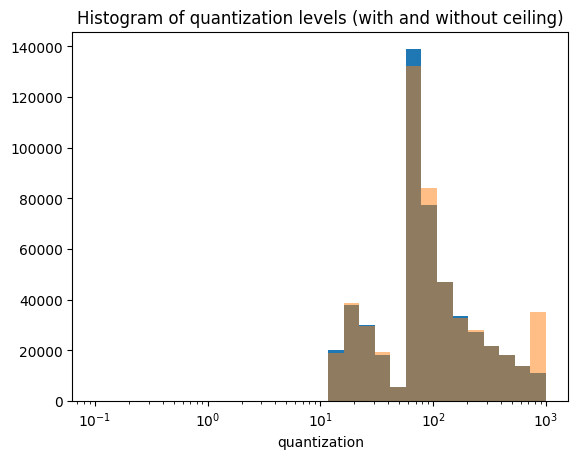

In [7]:
#kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
#k = np.sqrt(kx**2 + ky**2)*sub_image_size  # Calculate radial distance in Fourier space
avg_radial_power = avg_radial_power_spectrum_originals[np.round(k).astype(int)]
sqrt_half_avg_radial_power = np.sqrt(avg_radial_power/2) #2 is because of real and imaginary parts




# Get the decision boundaries and reconstruction levels for the desired level
#decision_boundaries, reconstruction_levels = quantization_values[level]

# Initialize lists to store decision boundaries and reconstruction levels
decision_boundaries_list = [[]]
reconstruction_levels_list = [[]]
decision_boundaries_list = np.zeros([max_levels, max_levels+1])
reconstruction_levels_list = np.zeros([max_levels, max_levels])
#probability_values_list = np.zeros([max_levels, maxma_levels])
entropy = np.zeros(max_levels)

# Loop over each level from 1 to max_level-1
for level in range(1, max_levels):
    decision_boundary, reconstruction_level = quantization_values[level]



    # Create new arrays filled with zeros
    new_decision_boundary = np.zeros(max_levels + 1)
    new_reconstruction_level = np.zeros(max_levels)

    # Copy elements, leaving the ends as zero
    new_decision_boundary[:level+1] = decision_boundary[:level+1]
    new_reconstruction_level[:level] = reconstruction_level[:level]

    decision_boundaries_list[level][:] = new_decision_boundary
    reconstruction_levels_list[level][:] = new_reconstruction_level

    #calculate probabilities
    probability_values =0.5 * (-erf(decision_boundary[:-1] / np.sqrt(2)) + erf(decision_boundary[1:] / np.sqrt(2))) +1e-300 #final is to avoid zero

   
    entropy[level] = -np.sum(probability_values*np.log2(probability_values))

    if np.isnan( entropy[level]):
        print("nan in entropy, level =", level, np.sum(probability_values))

# Convert lists to arrays
decision_boundaries = np.array(decision_boundaries_list)
reconstruction_levels = np.array(reconstruction_levels_list)

level = 8
print("db shapes ", np.shape(decision_boundaries[level]), np.shape(reconstruction_levels[level]))

fftimages_round = fftimages.copy()


single_level = False
Distortion = 1e-4

 #only use if single_level = False
if single_level:
    level = 8
else:
    optimal_arg = np.sqrt(avg_radial_power/(avg_power*Distortion))

    #to convert to uniform quantization I should use to get same distortion
    dx = np.sqrt(12)/optimal_arg #for uniform bins
    level_no_ceil = (2*nsigma_consider)/(dx) #ten is because of 10 sigma (should not hard code)
    level = np.minimum(np.ceil(level_no_ceil).astype(int), max_levels-1)  #This is using that bits = 1/2 log2(sigma^2/D) 
    # Calculate the data

    # Plot the histogram
    #print("data shape", np.shape(level_no_ceil))
    plt.hist(level_no_ceil.flatten(),  bins=np.logspace(np.log10(.1), np.log10(max_levels ), 30))  # You can adjust the number of bins as needed
    plt.hist(level.flatten(),  bins=np.logspace(np.log10(.1), np.log10(max_levels), 30), alpha=0.5)
    plt.gca().set_xscale("log")
    plt.xlabel('quantization')
    #plt.ylabel('Frequency')
    plt.title('Histogram of quantization levels (with and without ceiling)')
    plt.show()
    #so that levels = sqrt(sigma^2/D)


#print("shapes ", np.shape(decision_boundaries[level, 3]), np.shape(reconstruction_levels[level, 3]), np.shape(level), np.shape(fftimages_round[i]))

num_images_round = 30
for i in range(num_images_round):
    #print("image", i, " avg = ", np.average(fftimages_round[i].real**2/sqrt_half_avg_radial_power**2)) # Quantize the image   
  
    fftimages_round[i] = quantize_image(fftimages_round[i]/sqrt_half_avg_radial_power, level, decision_boundaries, reconstruction_levels, single_level )*sqrt_half_avg_radial_power


#added this line on 10/24 as seemed to be missing
rounded_images = [np.fft.irfft2(fftimage_round) for fftimage_round in fftimages_round]


#decision_boundaries_list = np.zeros((max_levels, max_levels+1))
#reconstruction_levels_list = np.zeros((max_levels, max_levels))


# This makes images of the Gaussian compressed data and compares to the original

Hurum: this isn't super important for this project;  I was just interested in sizes of errors and whether they agree with the fractional error parameter that we stared with

-0.03287455899644468 0.50556463
the absolute minimum and maximum diffeerence in a pixel: -0.0010595452 0.0011226088  This depends on the scale of the original image, so may not be super informative
the minimum and maximum diffeerence in a pixel divided by the pixel standard deviation: -0.05671562 0.0600913


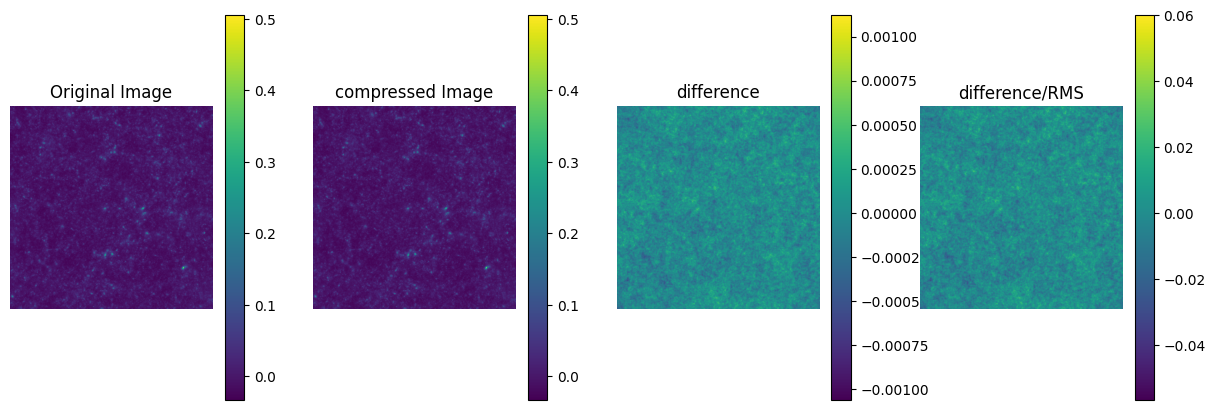

In [8]:
num_image_display = 2


# Assuming originals and reconstructions are your datasets
original_image = tf.squeeze(originals[num_image_display])

rounded_image = rounded_images[num_image_display]

# Determine the min and max values across both images for consistent scaling
vmin = min(original_image.numpy().min(), rounded_image.min())
vmax = max(original_image.numpy().max(), rounded_image.max())
print(vmin, vmax)

# Set up a figure with two subplots
plt.figure(figsize=(15, 5))  # You can adjust the figure size as needed

# Display the original image
plt.subplot(1, 4, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(original_image, vmin=vmin, vmax=vmax)
plt.title('Original Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()

# Display the reconstructed image
plt.subplot(1, 4, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(rounded_image, vmin=vmin, vmax=vmax)
plt.title('compressed Image')
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()


# Determine the scale for the difference image
difference_image = (original_image - rounded_image) #/np.std(original_image)
diff_vmin = difference_image.numpy().min()
diff_vmax = difference_image.numpy().max()

plt.subplot(1, 4, 3)
print("the absolute minimum and maximum diffeerence in a pixel:",  diff_vmin, diff_vmax, \
    " This depends on the scale of the original image, so may not be super informative")
plt.title('difference')

image_display= plt.imshow(difference_image, vmin=diff_vmin, vmax=diff_vmax)
plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()

# Determine the scale for the difference image
difference_image = (original_image - rounded_image)/np.std(original_image)
diff_vmin = difference_image.numpy().min()
diff_vmax = difference_image.numpy().max()

plt.subplot(1, 4, 4)
print("the minimum and maximum diffeerence in a pixel divided by the pixel standard deviation:",  diff_vmin, diff_vmax)
plt.title('difference/RMS')

image_display= plt.imshow(difference_image, vmin=diff_vmin, vmax=diff_vmax)


plt.axis('off')  # Turn off axis numbers and labels
plt.colorbar()



# This plots the hitogram of the difference image

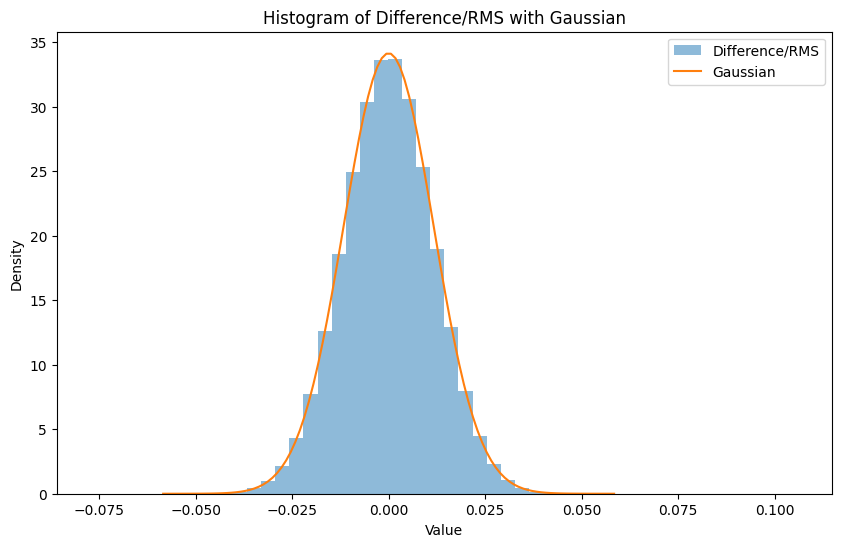

std of difference =  0.0116797425


In [9]:
import numpy as np
from scipy.stats import norm

# Flatten the difference image into a 1D array
originals_squeeze = tf.squeeze(originals)
sigma = np.std(originals_squeeze[:num_images_round].numpy().flatten())
difference_images = (originals_squeeze[:num_images_round] - rounded_images[:num_images_round])/sigma
difference_flat = difference_images.numpy().flatten()

# Calculate the RMS of the difference
rms = np.sqrt(np.mean(difference_flat**2))

# Generate the x values for the Gaussian
x = np.linspace(-5*rms, 5*rms, 100)

# Generate the y values for the Gaussian
y = norm.pdf(x, 0, rms)
#y = norm.pdf(x, 0, np.sqrt(Distortion))

# Create a figure
plt.figure(figsize=(10, 6))

# Plot the histogram of the difference
plt.hist(difference_flat, bins=50, alpha=0.5, label='Difference/RMS', density=True)

# Plot the Gaussian
plt.plot(x, y, label='Gaussian')

# Set the title and labels
plt.title('Histogram of Difference/RMS with Gaussian')
plt.xlabel('Value')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Display the plot
plt.show()

print("std of difference = ", np.std(difference_flat))

# Let's now compare power spectrum of rounded images to originals

shape: 1024 is_3d: False
shape: 1024 is_3d: False
shape: 1024 is_3d: False
725 725 725


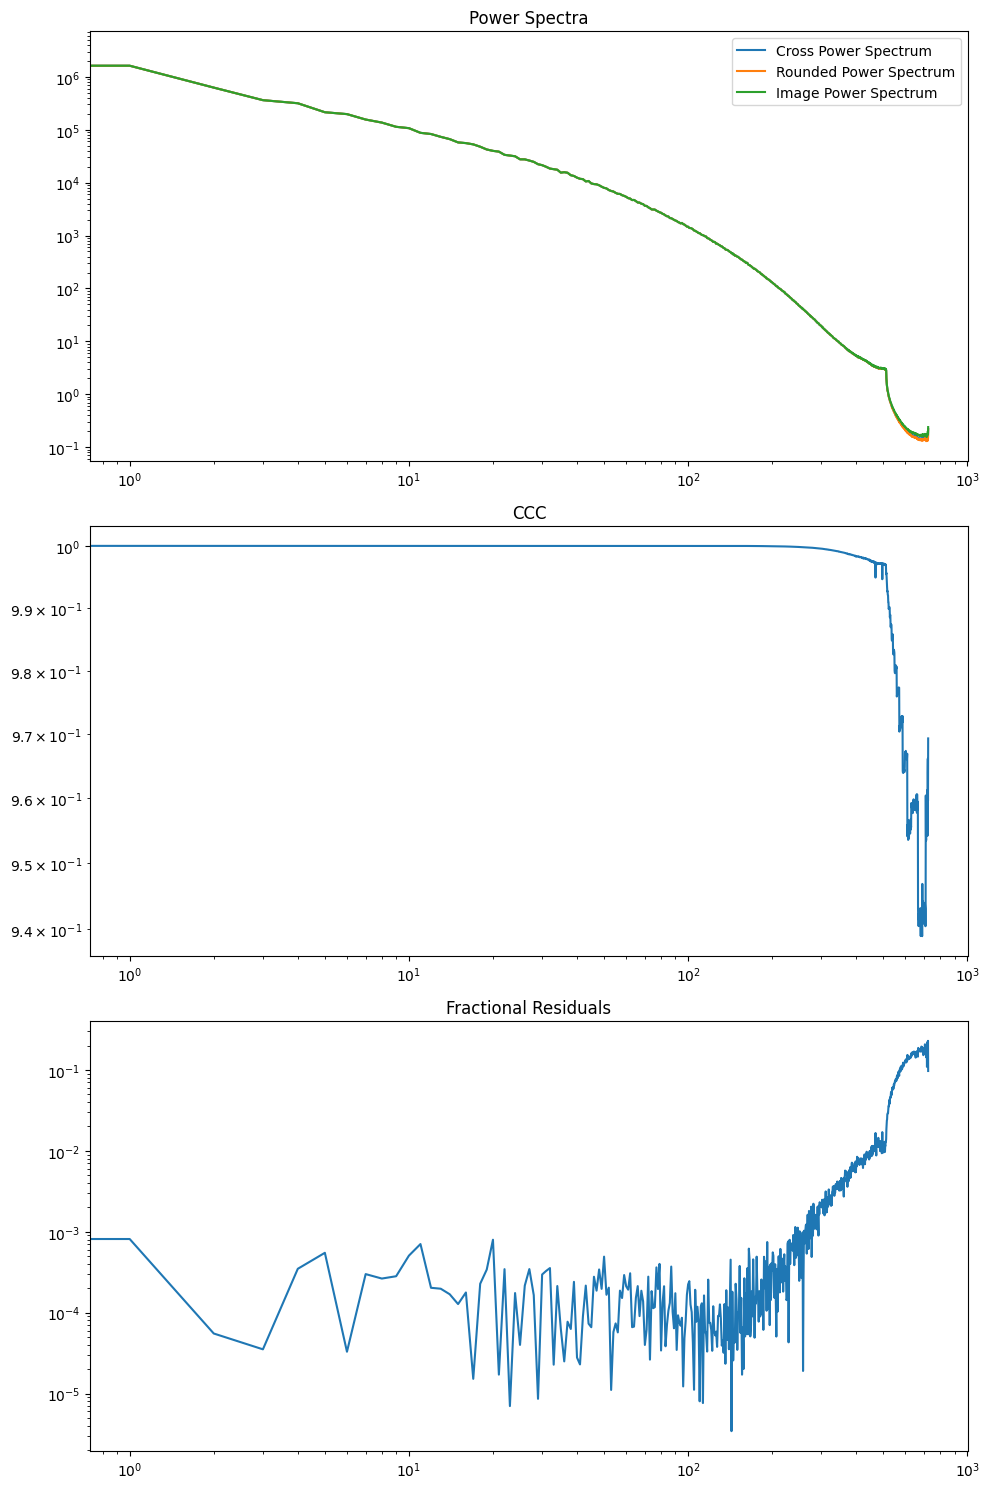

In [10]:
import power_spectrum as power

num_images_pk = 20 #len(fftimages_round)  #something is wrong with first image
cross_power = power.average_fft_cross_power_spectrum(fftimages[:num_images_pk],fftimages_round[:num_images_pk], sub_image_size) #only works if [:num_images_pk] is not added
rounded_power = power.average_fft_power_spectrum(fftimages_round[:num_images_pk], sub_image_size)
image_power = power.average_fft_power_spectrum(fftimages[:num_images_pk], sub_image_size)

print(len(cross_power), len(rounded_power), len(image_power))
ccc = cross_power/np.sqrt(rounded_power*image_power)


# Create a figure with 2 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the power spectra on the first subplot
axs[0].loglog(cross_power, label='Cross Power Spectrum')
axs[0].loglog(rounded_power, label='Rounded Power Spectrum')
axs[0].loglog(image_power, label='Image Power Spectrum')
axs[0].set_title('Power Spectra')
axs[0].legend()

# Plot ccc on the second subplot
axs[1].loglog(ccc)
axs[1].set_title('CCC')

# Plot the fractional residuals on the third subplot
# Calculate the fractional residuals
residuals = np.abs((rounded_power - image_power) / image_power)
axs[2].loglog(residuals)
axs[2].set_title('Fractional Residuals')

# Display the plots
plt.tight_layout()
plt.show()

# code to create a histogram at high wavenumbers to check Gaussian assumption

shape =  (512, 1225)
0.2915662746094584


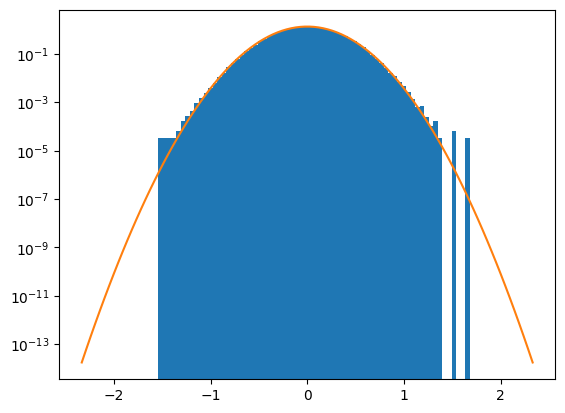

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming fftimages, kx, ky, kmin, kmax, and n are defined
kmin = 700  #(just selected to be near max for this simulation)
kmax = 800

# Calculate the radial wavenumber for each entry in fftimages
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size 
# Flatten the wavenumber array
#k_flat = k.flatten()

# Create a boolean mask for the desired wavenumber bin
mask = (k >= kmin) & (k < kmax)

# Select the first n images
fftimages_n = [fftimages[i][mask].real for i in range(num_images_use)]

print("shape = ", np.shape(fftimages_n))

# Flatten the images
#fftimages_n_flat = fftimages_n.flatten()



# Apply the mask to the flattened images
fftimages_flatten = np.array(fftimages_n).flatten()

sigma = np.std(fftimages_flatten)
print(sigma)

# Plot the histogram
plt.hist(fftimages_flatten, bins=100, range=[-8*sigma, 8*sigma], density=True)


x = np.linspace(-8*sigma, 8*sigma, 100)

# Generate the y values for the Gaussian
y = norm.pdf(x, 0, sigma)
# Plot the Gaussian
plt.plot(x, y, label='Gaussian')
plt.yscale('log')

plt.show()

# Calculate the KL divergence of box relative to a gaussian IID distribution

This is how many more bits you need to store because our method assumes a Gauassian distribution but the actua distribution is not gaussian.  THis is really interesting as this should be zero more bits at early cosmic times (when all cosmic fields are linear and GAussian) and later non Gaussianity will increase it

In [13]:
import numpy as np
from scipy.stats import norm

# Calculate the radial wavenumber for each entry in fftimages
kx, ky = np.meshgrid(np.fft.rfftfreq(sub_image_size), np.fft.fftfreq(sub_image_size))
k = np.sqrt(kx**2 + ky**2)*sub_image_size 
# Flatten the wavenumber array
#k_flat = k.flatten()

logkmin = np.log10(3)
logkmax = np.log10(np.max(k))
dlogk = 0.1
max_std_out = 8


numbins = int((logkmax - logkmin)/dlogk)
kbins = np.logspace(logkmin, logkmax, numbins)
total_max =0; total_KL =0; total_numberexcesbitsrelativetogaussian = 0
print("numkbins=", numbins, "num_iamges_use=", num_images_use)
for kmin, kmax in zip(kbins[:-1], kbins[1:]):
    # Create a boolean mask for the desired wavenumber bin
    mask = (k >= kmin) & (k < kmax)

    #    Select the first n images
    fftimages_nr = [fftimages[i][mask].real for i in range(num_images_use)]
    fftimages_ni = [fftimages[i][mask].imag for i in range(num_images_use)]

    # Apply the mask to the flattened images
    fftimages_flatten = np.array(np.concatenate((fftimages_nr, fftimages_ni), axis=0)).flatten()

    sigma = np.std(fftimages_flatten)
    #print(sigma)


  
    hist, bin_edges = np.histogram(fftimages_flatten, bins=200, range=[-max_std_out*sigma, max_std_out*sigma], density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dbin =  (-bin_edges[:-1] + bin_edges[1:]) 


    #print("summed hist = ", np.sum(hist*dbin))
    # Create a boolean mask for non-zero elements
    maskhist = (hist != 0)

    #print(hist[mask])
    # Apply the mask to hist and calculate the sum
    KLDiv = np.sum(hist[maskhist]*dbin[maskhist] * np.log2(hist[maskhist] / (norm.pdf(bin_centers[maskhist], 0, sigma))))


    numberexcesbitsrelativetogaussian = -np.sum(hist[maskhist]*dbin[maskhist] * np.log2(norm.pdf(bin_centers[maskhist], 0, sigma)*dbin[maskhist]) - norm.pdf(bin_centers[maskhist], 0, sigma)*dbin[maskhist] * np.log2(norm.pdf(bin_centers[maskhist], 0, sigma)*dbin[maskhist]))
    #this is excess over optimal compression of correct distribution



    numpix =2*np.sum(mask) #2 is for real and imaginary parts
    #print(kmin, kmax, "KL div = ", KLDiv, "numpix=", numpix, ", excess bits relative gaussian = ",  numberexcesbitsrelativetogaussian )
   
    total_max += numpix
    total_KL += KLDiv*numpix
    total_numberexcesbitsrelativetogaussian += numberexcesbitsrelativetogaussian*numpix

print("total KL = ", total_KL/total_max, " and to check I'm looking at all the pixels ", total_max, sub_image_size**2)
print("total numberexcesbitsrelativetogaussian = ", total_numberexcesbitsrelativetogaussian/total_max)

print("check binning", np.sum(hist[maskhist]*dbin[maskhist]), np.sum(norm.pdf(bin_centers[maskhist], 0, sigma)*dbin[maskhist]))

numkbins= 23 num_iamges_use= 512
total KL =  0.061817271093095545  and to check I'm looking at all the pixels  1050594 1048576
total numberexcesbitsrelativetogaussian =  -0.0014478667531406275
check binning 1.0 0.9999999998801073


# Now 3D cosmology simulations rather than the 2D maps used before

# Read in density of 3D Bolshoi sims

You can toggle between 256 and 512.  Both are in the tables in the paper.

LOGFIELD_3D explores whether we compress better if we first apply a log transform to the field before compressing. There are reasons to think this should help (e.g. the huge cosmological literature on how log transforms make density field more linear)

In [ ]:
import numpy as np
import pandas as pd

normalize_by_rms = True# the files have been saved with this on
old_read_in = False #very slow way of reading in using the files I have saved in cgmbrush  (leave as False)
LOGFIELD_3D = False

resolution =256 #256 or 512
if old_read_in:
    resStr = str(resolution) #reads in the 256^3 or 512^3 simulation
    file_path = "/Users/matt/Dropbox/CGMBrush/cgm-brush/cgmbrush/sims/dens" + resStr +"-z-0.csv.gz"

    pdDens=pd.read_csv(file_path)

    # extracting columns
    pdDensN=pdDens[['Bolshoi__Dens'+resStr+'_z0__ix','Bolshoi__Dens'+resStr+'_z0__iy','Bolshoi__Dens'+resStr+'_z0__iz','Bolshoi__Dens'+resStr+'_z0__dens']]

    # 3D density array
    pdDensN=pdDensN.sort_values(['Bolshoi__Dens'+resStr+'_z0__ix','Bolshoi__Dens'+resStr+'_z0__iy','Bolshoi__Dens'+resStr+'_z0__iz'])
    tden = pdDensN['Bolshoi__Dens'+resStr+'_z0__dens'].values
    tden = np.reshape(tden,(resolution,resolution,resolution))
    #return normDM((tden2+1).sum(2), 0, resolution, self.Lbox)

    meanf = np.mean(tden)
    print("mean of field is ", meanf, np.sum(tden<-1))#12 points in the 512 are barely less than -1
    tden[tden<-1]=-1.0

    tden = tden +1 #convert overdensity field to 1+delta

    print("read in density:", file_path, " type =", tden.dtype)

    tden.tofile(f'Bolshoi_{resolution}.bin')  #If want to write out file for quicker reading
else:
    # Assuming the data type is float and the shape is (resolution, resolution, resolution)
    dtype = np.float64
    shape = (resolution, resolution, resolution)

    tden = np.fromfile(f'Bolshoi_{resolution}.bin', dtype=dtype) # read in 1+ overdensity field
    print("read in density from binary file, type =", f'Bolshoi_{resolution}.bin')
    tden = tden.reshape(shape)


if LOGFIELD_3D:
    rmsf = np.sqrt(np.mean(tden**2))
    minf = np.min(tden)
    maxf = np.max(tden)
    print("rmsf = ", rmsf, minf, maxf)
    tden = np.log(tden/rmsf + 1e-30) #nomralize by RMS

    if np.isnan(tden).any() or np.isinf(tden).any():
        print("there are NANs in the field")

read in density from binary file  Bolshoi_256.bin


## calculate the number of bits required to store the power spectrum assuming the simulation is Gaussian

In [27]:
# calculate number of bits
#import importlib
#importlib.reload(power)
#importlib.reload(power)
import power_spectrum as power

fftfield = np.fft.rfftn(tden)

print("shape = ", fftfield.shape)

avg_radial_power_spectrum3D = power.average_fft_power_spectrum(fftfield[np.newaxis, ...], resolution, True)
avg_power3D = np.mean(np.abs(fftfield)**2)

frac_error = 0.001
Dval = frac_error**2

avg_radial_power3D = avg_radial_power_spectrum3D[np.round(k).astype(int)]
optimal_arg3D = np.sqrt(avg_radial_power3D/(avg_power3D*Dval))

condition = optimal_arg3D > 1

Dvalcorrected = Dval - np.sum(avg_radial_power3D[~condition])/np.sum(avg_radial_power3D)
print("Dvals ", Dval, Dvalcorrected)
optimal_arg3D_waterfill = np.sqrt(avg_radial_power3D/(avg_power3D*Dvalcorrected))

if np.any(condition == False):
        print("note that some pixels are zero, so calculation is not correct, the fraction of pixels equal to zero is ", np.sum(condition == False)/np.size(condition))

# This always gives at least 1 bit to every mode
#gaussian_min_number_bits = np.average(np.maximum(np.log2(optimal_arg3D), 1)) #no divide by two as we've taken a square root above

#print(f"Rg(D={Dval})=", gaussian_min_number_bits)


# This always gives at least 1 bit to every mode
gaussian_min_number_bits_notquite = np.average(np.maximum(np.log2(optimal_arg3D), 0)) #allocate bits to all wavenumber bins, even those that contribute very little power, 
                                                                                   #which is not optimal but is a common approach in the literature; 
gaussian_min_number_bits_waterfill = np.average(np.maximum(np.log2(optimal_arg3D_waterfill), 0)) #allocate bits to all wavenumber bins that contribute power, but correct Dval to account for the fact that some bins are not allocated any bits;
                                                                                               # this is a more optimal approach than the previous one
gaussian_min_number_bits_nozero = np.average(np.maximum(np.log2(optimal_arg3D), 1)) #allocate bits to all wavenumber bins that contribute power, 
                                                        #but set a minimum of 1 bit per bin, which is not optimal 
                                                        # but it makes sense to store info about these modes.

print(f"log = {LOGFIELD_3D}, Rg(D={Dval})=", gaussian_min_number_bits_notquite, gaussian_min_number_bits_waterfill, gaussian_min_number_bits_nozero)
print(f"The latter three numbers are the number of bits (the Rate) needed to compress the field with a mean squared error equal to Dval,\n \
         which is the distortion (the MSE) allowed in the compression. \n \
                 Each number is making differnet assumptions for how to handle the highest k.")


shape =  (256, 256, 129)
shape: 256 is_3d: True
Dvals  1e-06 9.612834890133341e-07
note that some pixels are zero, so calculation is not correct, the fraction of pixels equal to zero is  0.2313496197840964
log = False, Rg(D=1e-06)= 4.037565919347336 4.059459442162763 4.3000859273815655
The latter three numbers are the number of bits (the Rate) needed to compress the field with a mean squared error equal to Dval,
          which is the distortion (the MSE) allowed in the compression. 
                  Each number is making differnet assumptions for how to handle the highest k.


# Now we will apply the same KL divergence to Bolshoi to see how many 

In [ ]:
import numpy as np
from scipy.stats import norm

fftfield = np.fft.rfftn(tden)


# Calculate the radial wavenumber for each entry in fftimages
kx, ky, kz = np.meshgrid(np.fft.fftfreq(resolution), np.fft.fftfreq(resolution), np.fft.rfftfreq(resolution))
k = np.sqrt(kx**2 + ky**2+ kz**2)*resolution
# Flatten the wavenumber array
#k_flat = k.flatten()

logkmin = np.log10(3)
logkmax = np.log10(np.max(k))
dlogk = 0.1
max_std_out = 8


numbins = int((logkmax - logkmin)/dlogk)
kbins = np.logspace(logkmin, logkmax, numbins)
total_max =0; total_KL =0

for kmin, kmax in zip(kbins[:-1], kbins[1:]):
    # Create a boolean mask for the desired wavenumber bin
    mask = (k >= kmin) & (k < kmax)

    # Apply the mask to the flattened images
    fftimages_flatten = np.array(np.concatenate((fftfield[mask].real, fftfield[mask].imag), axis=0)).flatten()

    sigma = np.std(fftimages_flatten)
    #print(sigma)

    hist, bin_edges = np.histogram(fftimages_flatten, bins=200, range=[-max_std_out*sigma, max_std_out*sigma], density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    dbin =  (-bin_edges[:-1] + bin_edges[1:]) 

    # Create a boolean mask for non-zero elements
    maskhist = (hist != 0)

    #print(hist[mask])
    # Apply the mask to hist and calculate the sum
    KLDiv = np.sum(hist[maskhist]* dbin[maskhist] * np.log2(hist[maskhist] / (norm.pdf(bin_centers[maskhist], 0, sigma))))

    numpix =2*np.sum(mask) #2 is for real and imaginary parts
    #print(kmin, kmax, "KL div = ", KLDiv, "numpix=", numpix)
   
    total_max += numpix
    total_KL += KLDiv*numpix

print("total KL = ", total_KL/total_max, " and to check I'm looking at all the pixels ", total_max, resolution**3)

3.0 3.864041697101024 KL div =  0.33657500763646686 numpix= 178
3.864041697101024 4.976939412311786 KL div =  0.2564822607090252 numpix= 258
4.976939412311786 6.4103671377060705 KL div =  0.09084950593261522 numpix= 724
6.4103671377060705 8.256641971274131 KL div =  0.04383898452041684 numpix= 1316
8.256641971274131 10.634669618345878 KL div =  0.027158210347491815 numpix= 2804
10.634669618345878 13.697602280060634 KL div =  0.009279180989469994 numpix= 6022
13.697602280060634 17.642702120153448 KL div =  0.005312395031110715 numpix= 12536
17.642702120153448 22.724045547268517 KL div =  0.003957070398760578 numpix= 26834
22.724045547268517 29.268886507156132 KL div =  0.0016462468837646885 numpix= 56926
29.268886507156132 37.69873263045628 KL div =  0.0010088861403034647 numpix= 121528
37.69873263045628 48.556491603981996 KL div =  0.0012420397866609297 numpix= 257942
48.556491603981996 62.541436074240764 KL div =  0.004929725649887927 numpix= 549964
62.541436074240764 80.5542389291481

## The following calls pysz -- the python libary associated with the SZ compression tool

You will have to install this code to use the following
Also, in order ot get the same RMS distortion as for the Gaussian (as is necessary for an apples to apples comparison),
you need to adjust the SZ parameters to get a similar distortion.  The below does this for their abs_error (and maybe also their pointwise error which is commented out).  I think I found you want to set the absolute error to be about twice the RMS error you intend....the following should also compute the RMS error

In [28]:
import sys
import importlib
from pathlib import Path

not_run_yet = True
data_is_3D = True
SZ_GENERATED = False
show_histogram = True
max_images_use = 1000

print("running SZ")
breakpoint()
#3e-2 absolute error results in same distortion as .01
abs_error, rel_error, eb_pwr= 0, 0, 0 #set to zero

eb_mode = 0; abs_error = 2e-3  #this absolute error increase results in std that is 2 times smaller (would be 1/sqrt(12) if perfectly flat)
#eb_mode = 10; eb_pwr = 1e-2 #point wise error

#sys.path.append('/Users/matt/Dropbox/learning_neuralnets/weaklensing_ML/SZ3/tools/')
if not_run_yet:
    sys.path.append('/Users/matt/Dropbox/learning_neuralnets/weaklensing_ML/SZ3/tools/pysz/')
    not_run_yet = False

from pysz  import SZ

lib_extention = {
    "darwin": "libSZ3c.dylib",
    "windows": "SZ3c.dll",
}.get(sys.platform, "libSZ3c.so")

sz = SZ("/Users/matt/Dropbox/learning_neuralnets/weaklensing_ML/SZ3/lib/{}".format(lib_extention))

#the 3D data is one file, so that's why there are different codes
if data_is_3D:
    data = tden/tden.std() #np.reshape(data, (100, 500, 500))

    # compress, both input and output data are numpy array
    data_cmpr, cmpr_ratio = sz.compress(data, eb_mode, abs_error, rel_error, eb_pwr)
    print("compression ratio = {:5G}".format(cmpr_ratio))
    print("bits per pixel = {:.5G}".format(data.dtype.itemsize * 8/cmpr_ratio))

    # decompress, both input and output data are numpy array
    data_dec = sz.decompress(data_cmpr, data.shape, data.dtype)

    # verify
    distortions = sz.verify(data, data_dec)
    
    if show_histogram:
        import matplotlib.pyplot as plt

        # Calculate the difference between data and data_dec
        diff = data - data_dec

        # Flatten the difference for histogram
        diff_flat = diff.flatten()

        if eb_pwr !=0:
            diff_flat = diff_flat/data.flatten()

        # Plot histogram of the difference
        plt.hist(diff_flat, bins=50, color='g', alpha=0.7)

        if eb_pwr !=0:
             plt.title('Histogram of the fractional difference')
        else:
            plt.title('Histogram of the difference')
        plt.title('Difference between Original and Decompressed Data')

        plt.show()

else:
    data_cmpr_array = []; cmpr_ratio_array = []; distortions_array = []
    for original in originals[:max_images_use]:
        data = original.numpy()/original.numpy().std()
        # compress, both input and output data are numpy array
        data_cmpr, cmpr_ratio = sz.compress(data, eb_mode, abs_error, rel_error, eb_pwr)
        data_cmpr_array.append(data_cmpr)
        cmpr_ratio_array.append(cmpr_ratio)

        # decompress, both input and output data are numpy array
        data_dec = sz.decompress(data_cmpr, data.shape, data.dtype)

        # verify
        distortions_array.append(sz.verify(data, data_dec))
    cmpr_ratio=np.average(cmpr_ratio_array)
    distortions = np.mean(distortions_array, axis=0)


print("compression ratio = {:5G}".format(cmpr_ratio))
print("bits per pixel = {:.5G}".format(data.dtype.itemsize * 8/cmpr_ratio))

print("The sqrt(mse)/std = ", distortions[-1])

SZ_GENERATED =True



running SZ


ModuleNotFoundError: No module named 'pysz'

## plot the power spectrum of the SZ compressed field (should really look at residuals)

shape: 256 is_3d: True


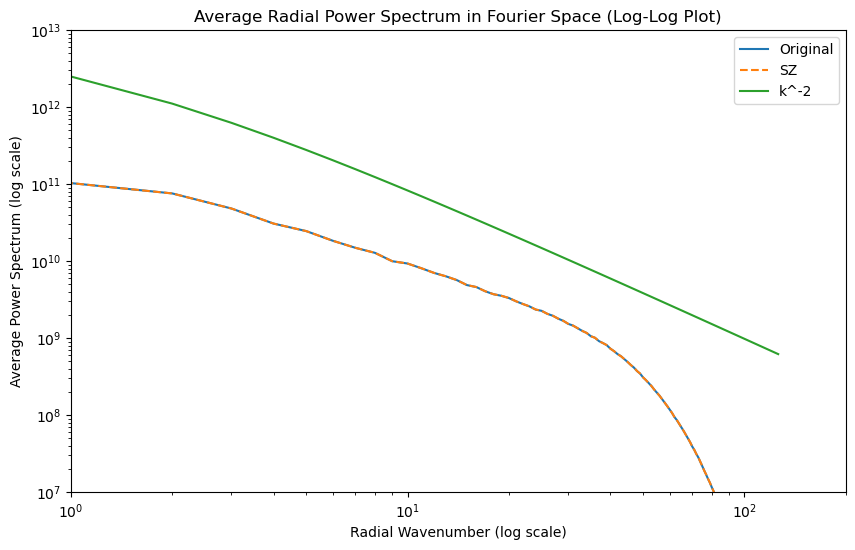

In [110]:

plt.figure(figsize=(10, 6))
# Plot for originals with markers
plt.loglog(avg_radial_power_spectrum3D, label='Original', linestyle='-')

if SZ_GENERATED:
    data_dec_fft = np.fft.rfftn(data_dec)
    avg_radial_power_spectrum3D_SZ = power.average_fft_power_spectrum(data_dec_fft[np.newaxis, ...], resolution, True)
    plt.loglog(avg_radial_power_spectrum3D_SZ, label='SZ', linestyle='--')

kbins = np.array(np.arange(1, resolution//2), dtype=np.float64)
plt.loglog(1e13*kbins**-2, label='k^-2', linestyle='-')

#plt.loglog(average_fft_cross_power_spectrum(fftimages,fftimages, sub_image_size), label='cross', marker='x', linestyle='-') #for testing

plt.xlabel('Radial Wavenumber (log scale)')
plt.ylabel('Average Power Spectrum (log scale)')
plt.title('Average Radial Power Spectrum in Fourier Space (Log-Log Plot)')
plt.xlim([1, 200])
plt.ylim([1e7, 1e13])
plt.legend()

plt.show()